<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 340, '日付': '2021-02-25T08:00:00.000Z'},
 {'小計': 270, '日付': '2021-02-26T08:00:00.000Z'},
 {'小計': 337, '日付': '2021-02-27T08:00:00.000Z'},
 {'小計': 329, '日付': '2021-02-28T08:00:00.000Z'},
 {'小計': 121, '日付': '2021-03-01T08:00:00.000Z'},
 {'小計': 232, '日付': '2021-03-02T08:00:00.000Z'},
 {'小計': 316, '日付': '2021-03-03T08:00:00.000Z'},
 {'小計': 279, '日付': '2021-03-04T08:00:00.000Z'},
 {'小計': 301, '日付': '2021-03-05T08:00:00.000Z'},
 {'小計': 293, '日付': '2021-03-06T08:00:00.000Z'},
 {'小計': 237, '日付': '2021-03-07T08:00:00.000Z'},
 {'小計': 116, '日付': '2021-03-08T08:00:00.000Z'},
 {'小計': 290, '日付': '2021-03-09T08:00:00.000Z'},
 {'小計': 340, '日付': '2021-03-10T08:00:00.000Z'},
 {'小計': 335, '日付': '2021-03-11T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2021-03-07 17:00:00+09:00,192,0,237,2021-03-07 17:00:00+09:00
2021-03-08 17:00:00+09:00,277,0,116,2021-03-08 17:00:00+09:00
2021-03-09 17:00:00+09:00,240,0,290,2021-03-09 17:00:00+09:00
2021-03-10 17:00:00+09:00,241,0,340,2021-03-10 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2021-03-07 17:00:00+09:00,192,0,237,2021-03-07 17:00:00+09:00,227.142857,1590.0,0.0,0.0,254.142857,1779.0
2021-03-08 17:00:00+09:00,277,0,116,2021-03-08 17:00:00+09:00,228.714286,1601.0,0.0,0.0,253.428571,1774.0
2021-03-09 17:00:00+09:00,240,0,290,2021-03-09 17:00:00+09:00,233.000000,1631.0,0.0,0.0,261.714286,1832.0
2021-03-10 17:00:00+09:00,241,0,340,2021-03-10 17:00:00+09:00,238.714286,1671.0,0.0,0.0,265.142857,1856.0
2021-03-11 17:00:00+09:00,0,0,335,2021-03-11 17:00:00+09:00,205.571429,1439.0,0.0,0.0,273.142857,1912.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2021-02-25 17:00:00+09:00,213,0,340,2021-02-25 17:00:00+09:00,236.000000,1652.0,0.0,0.0,279.714286,1958.0,'21w08,Thu
2021-02-26 17:00:00+09:00,213,0,270,2021-02-26 17:00:00+09:00,237.857143,1665.0,0.0,0.0,267.857143,1875.0,'21w08,Fri
2021-02-27 17:00:00+09:00,297,0,337,2021-02-27 17:00:00+09:00,242.571429,1698.0,0.0,0.0,269.285714,1885.0,'21w08,Sat
2021-02-28 17:00:00+09:00,211,0,329,2021-02-28 17:00:00+09:00,238.571429,1670.0,0.0,0.0,277.428571,1942.0,'21w08,Sun
2021-03-01 17:00:00+09:00,266,0,121,2021-03-01 17:00:00+09:00,238.857143,1672.0,0.0,0.0,269.285714,1885.0,'21w09,Mon
2021-03-02 17:00:00+09:00,210,0,232,2021-03-02 17:00:00+09:00,235.285714,1647.0,0.0,0.0,263.142857,1842.0,'21w09,Tue
2021-03-03 17:00:00+09:00,201,0,316,2021-03-03 17:00:00+09:00,230.142857,1611.0,0.0,0.0,277.857143,1945.0,'21w09,Wed
2021-03-04 17:00:00+09:00,232,0,279,2021-03-04 17:00:00+09:00,232.857143,1630.0,0.0,0.0,269.142857,1884.0,'21w09,Thu
2021-03-05 17:00:00+09:00,246,0,301,2021-03-05 17:00:00+09:00,237.571429,1663.0,0.0,0.0,273.571429,1915.0,'21w09,Fri
2021-03-06 17:00:00+09:00,243,0,293,2021-03-06 17:00:00+09:00,229.857143,1609.0,0.0,0.0,267.285714,1871.0,'21w09,Sat


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2021-02-21 17:00:00+09:00,341.571429,2391
2021-02-28 17:00:00+09:00,277.428571,1942
2021-03-07 17:00:00+09:00,254.142857,1779
2021-03-11 17:00:00+09:00,270.250000,1081
2021-01-03 17:00:00+09:00,816.000000,2448


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2021-02-25 17:00:00+09:00,213,0,340,2021-02-25 17:00:00+09:00,236.000000,1652.0,0.0,0.0,279.714286,1958.0,'21w08,Thu,NaN,NaN
2021-02-26 17:00:00+09:00,213,0,270,2021-02-26 17:00:00+09:00,237.857143,1665.0,0.0,0.0,267.857143,1875.0,'21w08,Fri,NaN,NaN
2021-02-27 17:00:00+09:00,297,0,337,2021-02-27 17:00:00+09:00,242.571429,1698.0,0.0,0.0,269.285714,1885.0,'21w08,Sat,NaN,NaN
2021-02-28 17:00:00+09:00,211,0,329,2021-02-28 17:00:00+09:00,238.571429,1670.0,0.0,0.0,277.428571,1942.0,'21w08,Sun,277.428571,1942.0
2021-03-01 17:00:00+09:00,266,0,121,2021-03-01 17:00:00+09:00,238.857143,1672.0,0.0,0.0,269.285714,1885.0,'21w09,Mon,NaN,NaN
2021-03-02 17:00:00+09:00,210,0,232,2021-03-02 17:00:00+09:00,235.285714,1647.0,0.0,0.0,263.142857,1842.0,'21w09,Tue,NaN,NaN
2021-03-03 17:00:00+09:00,201,0,316,2021-03-03 17:00:00+09:00,230.142857,1611.0,0.0,0.0,277.857143,1945.0,'21w09,Wed,NaN,NaN
2021-03-04 17:00:00+09:00,232,0,279,2021-03-04 17:00:00+09:00,232.857143,1630.0,0.0,0.0,269.142857,1884.0,'21w09,Thu,NaN,NaN
2021-03-05 17:00:00+09:00,246,0,301,2021-03-05 17:00:00+09:00,237.571429,1663.0,0.0,0.0,273.571429,1915.0,'21w09,Fri,NaN,NaN
2021-03-06 17:00:00+09:00,243,0,293,2021-03-06 17:00:00+09:00,229.857143,1609.0,0.0,0.0,267.285714,1871.0,'21w09,Sat,NaN,NaN


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

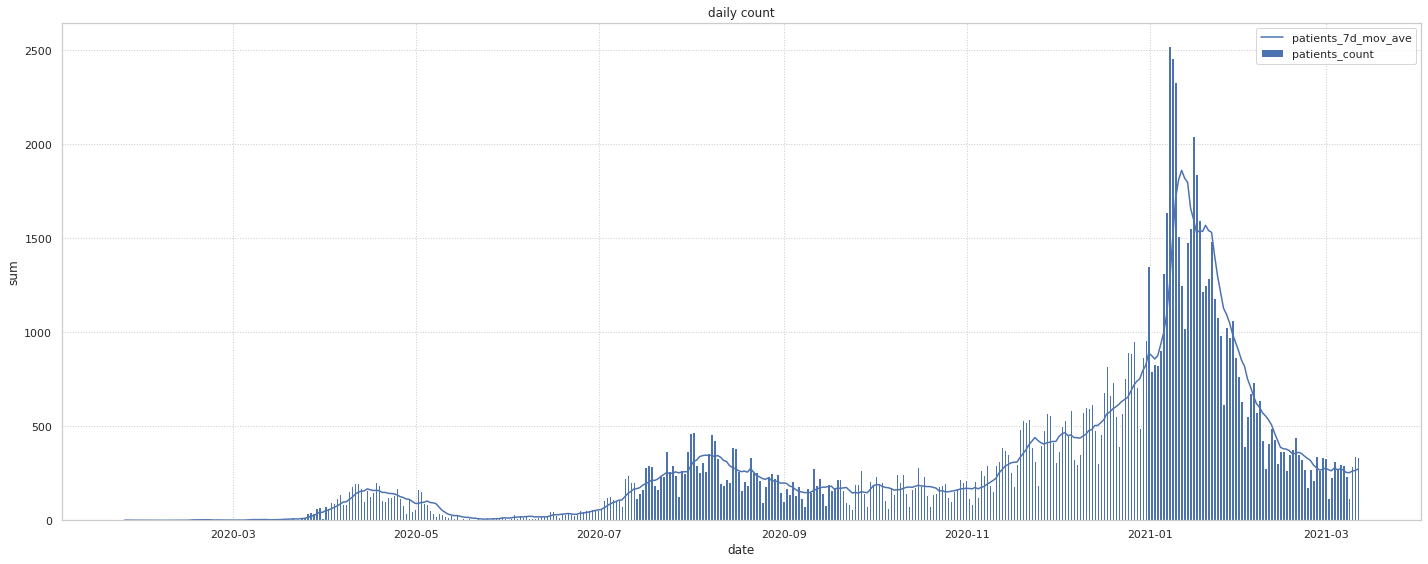

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
398,1.614240e+09,2021,2,25,0,0,0,0,1,0,0,398,0,324,213,236.000000,1652.0,0,0.0,0.0,340,279.714286,1958.0
399,1.614326e+09,2021,2,26,1,0,0,0,0,0,0,399,0,325,213,237.857143,1665.0,0,0.0,0.0,270,267.857143,1875.0
400,1.614413e+09,2021,2,27,0,0,1,0,0,0,0,400,0,326,297,242.571429,1698.0,0,0.0,0.0,337,269.285714,1885.0
401,1.614499e+09,2021,2,28,0,0,0,1,0,0,0,401,0,327,211,238.571429,1670.0,0,0.0,0.0,329,277.428571,1942.0
402,1.614586e+09,2021,3,1,0,1,0,0,0,0,0,402,0,328,266,238.857143,1672.0,0,0.0,0.0,121,269.285714,1885.0
403,1.614672e+09,2021,3,2,0,0,0,0,0,1,0,403,0,329,210,235.285714,1647.0,0,0.0,0.0,232,263.142857,1842.0
404,1.614758e+09,2021,3,3,0,0,0,0,0,0,1,404,0,330,201,230.142857,1611.0,0,0.0,0.0,316,277.857143,1945.0
405,1.614845e+09,2021,3,4,0,0,0,0,1,0,0,405,0,331,232,232.857143,1630.0,0,0.0,0.0,279,269.142857,1884.0
406,1.614931e+09,2021,3,5,1,0,0,0,0,0,0,406,0,332,246,237.571429,1663.0,0,0.0,0.0,301,273.571429,1915.0
407,1.615018e+09,2021,3,6,0,0,1,0,0,0,0,407,0,333,243,229.857143,1609.0,0,0.0,0.0,293,267.285714,1871.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            413 non-null    float64
 1   year                 413 non-null    int64  
 2   month                413 non-null    int64  
 3   day                  413 non-null    int64  
 4   Fri                  413 non-null    uint8  
 5   Mon                  413 non-null    uint8  
 6   Sat                  413 non-null    uint8  
 7   Sun                  413 non-null    uint8  
 8   Thu                  413 non-null    uint8  
 9   Tue                  413 non-null    uint8  
 10  Wed                  413 non-null    uint8  
 11  passed               413 non-null    int64  
 12  emergency            413 non-null    int64  
 13  em_passed            413 non-null    int64  
 14  contacts_count       413 non-null    int64  
 15  contacts_7d_mov_ave  413 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,4.130000e+02,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.00000
mean,1.597651e+09,2020.169492,6.007264,15.639225,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,206.000000,0.118644,138.719128,714.467312,713.215439,4992.498789,892.297821,892.297821,6246.084746,277.326877,275.262297,1926.79661
std,1.031332e+07,0.375641,3.553672,8.893278,0.350352,0.350352,0.350352,0.350352,0.350352,0.350352,0.350352,119.367081,0.323761,109.957090,461.291793,447.127072,3129.904269,882.345014,773.819317,5416.735221,376.638971,357.359041,2501.54370
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1.588752e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.000000,0.000000,29.000000,406.000000,431.428571,3020.000000,0.000000,0.000000,0.000000,35.000000,32.571429,228.00000
50%,1.597651e+09,2020.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,132.000000,574.000000,588.714286,4121.000000,878.000000,1012.285714,7086.000000,171.000000,169.857143,1189.00000
75%,1.606550e+09,2020.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,309.000000,0.000000,235.000000,870.000000,893.571429,6255.000000,1476.000000,1462.571429,10238.000000,329.000000,333.857143,2337.00000
max,1.615450e+09,2021.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,412.000000,1.000000,338.000000,2265.000000,2096.857143,14678.000000,4060.000000,2574.142857,18019.000000,2520.000000,1861.142857,13028.00000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,6.498422e-01,0.278428,-0.026701,-1.027277e-02,-1.000969e-17,-6.848512e-03,-3.424256e-03,1.027277e-02,3.424256e-03,6.848512e-03,1.000000e+00,-3.323632e-01,0.992354,-0.197298,-0.168200,-0.168195,-0.397493,-4.241897e-01,-4.241897e-01,0.620768,0.663626,0.663645
year,6.498422e-01,1.000000e+00,-0.546399,-0.092088,-2.457072e-17,-1.228536e-17,-2.457072e-17,-2.457072e-17,-2.457072e-17,-2.457072e-17,-2.457072e-17,6.498422e-01,-1.657484e-01,0.677816,-0.167775,-0.126993,-0.126991,-0.457404,-5.215532e-01,-5.215532e-01,0.597204,0.668864,0.668863
month,2.784280e-01,-5.463987e-01,1.000000,0.004998,-1.253245e-02,1.113995e-03,-8.633463e-03,-4.734480e-03,1.086145e-02,5.012979e-03,8.911962e-03,2.784280e-01,-1.547517e-01,0.234176,-0.002913,-0.022677,-0.022673,0.142341,1.958353e-01,1.958353e-01,-0.074204,-0.118938,-0.118914
day,-2.670083e-02,-9.208776e-02,0.004998,1.000000,1.424455e-02,-1.302041e-02,1.190756e-02,1.112856e-02,6.454563e-03,-1.457841e-02,-1.613641e-02,-2.670083e-02,2.257464e-03,-0.026139,0.000195,0.001738,0.001733,0.022100,6.123601e-03,6.123601e-03,-0.009248,0.001313,0.001296
Fri,-1.027277e-02,-2.457072e-17,-0.012532,0.014245,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.027277e-02,-1.410547e-17,-0.009100,-0.017700,-0.001496,-0.001495,0.042842,2.290087e-18,-7.851726e-18,0.048591,-0.002084,-0.002094
Mon,-1.000969e-17,-1.228536e-17,0.001114,-0.013020,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,5.567217e-18,2.524137e-18,-0.000027,0.042253,0.000080,0.000081,0.169395,1.348607e-17,5.525288e-18,-0.107646,-0.000307,-0.000305
Sat,-6.848512e-03,-2.457072e-17,-0.008633,0.011908,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-6.848512e-03,2.524137e-18,-0.006075,0.049537,-0.000958,-0.000957,-0.195534,2.544541e-19,-9.014944e-18,0.053098,-0.001275,-0.001282
Sun,-3.424256e-03,-2.457072e-17,-0.004734,0.011129,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,-1.666667e-01,-3.424256e-03,2.524137e-18,-0.003051,-0.015598,-0.000533,-0.000532,-0.180153,8.396984e-18,1.192299e-17,-0.032783,-0.000625,-0.000626
Thu,1.027277e-02,-2.457072e-17,0.010861,0.006455,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,-1.666667e-01,1.027277e-02,2.672615e-18,0.009172,-0.015282,0.001144,0.001146,0.049422,1.628506e-17,1.628506e-17,0.076145,0.002361,0.002368
Tue,3.424256e-03,-2.457072e-17,0.005013,-0.014578,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,-1.666667e-01,1.000000e+00,-1.666667e-01,3.424256e-03,4.454359e-19,0.002997,-0.025900,0.000611,0.000612,0.067582,9.414801e-18,1.134138e-17,-0.037878,0.000494,0.000498


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408,1.615104e+09,0,0,0,1,0,0,0,408,0,334,192,0,237,254.142857,1779.0
409,1.615190e+09,0,1,0,0,0,0,0,409,0,335,277,0,116,253.428571,1774.0
410,1.615277e+09,0,0,0,0,0,1,0,410,0,336,240,0,290,261.714286,1832.0
411,1.615363e+09,0,0,0,0,0,0,1,411,0,337,241,0,340,265.142857,1856.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
408,1.615104e+09,408,0,237,254.142857,1779.0
409,1.615190e+09,409,0,116,253.428571,1774.0
410,1.615277e+09,410,0,290,261.714286,1832.0
411,1.615363e+09,411,0,340,265.142857,1856.0


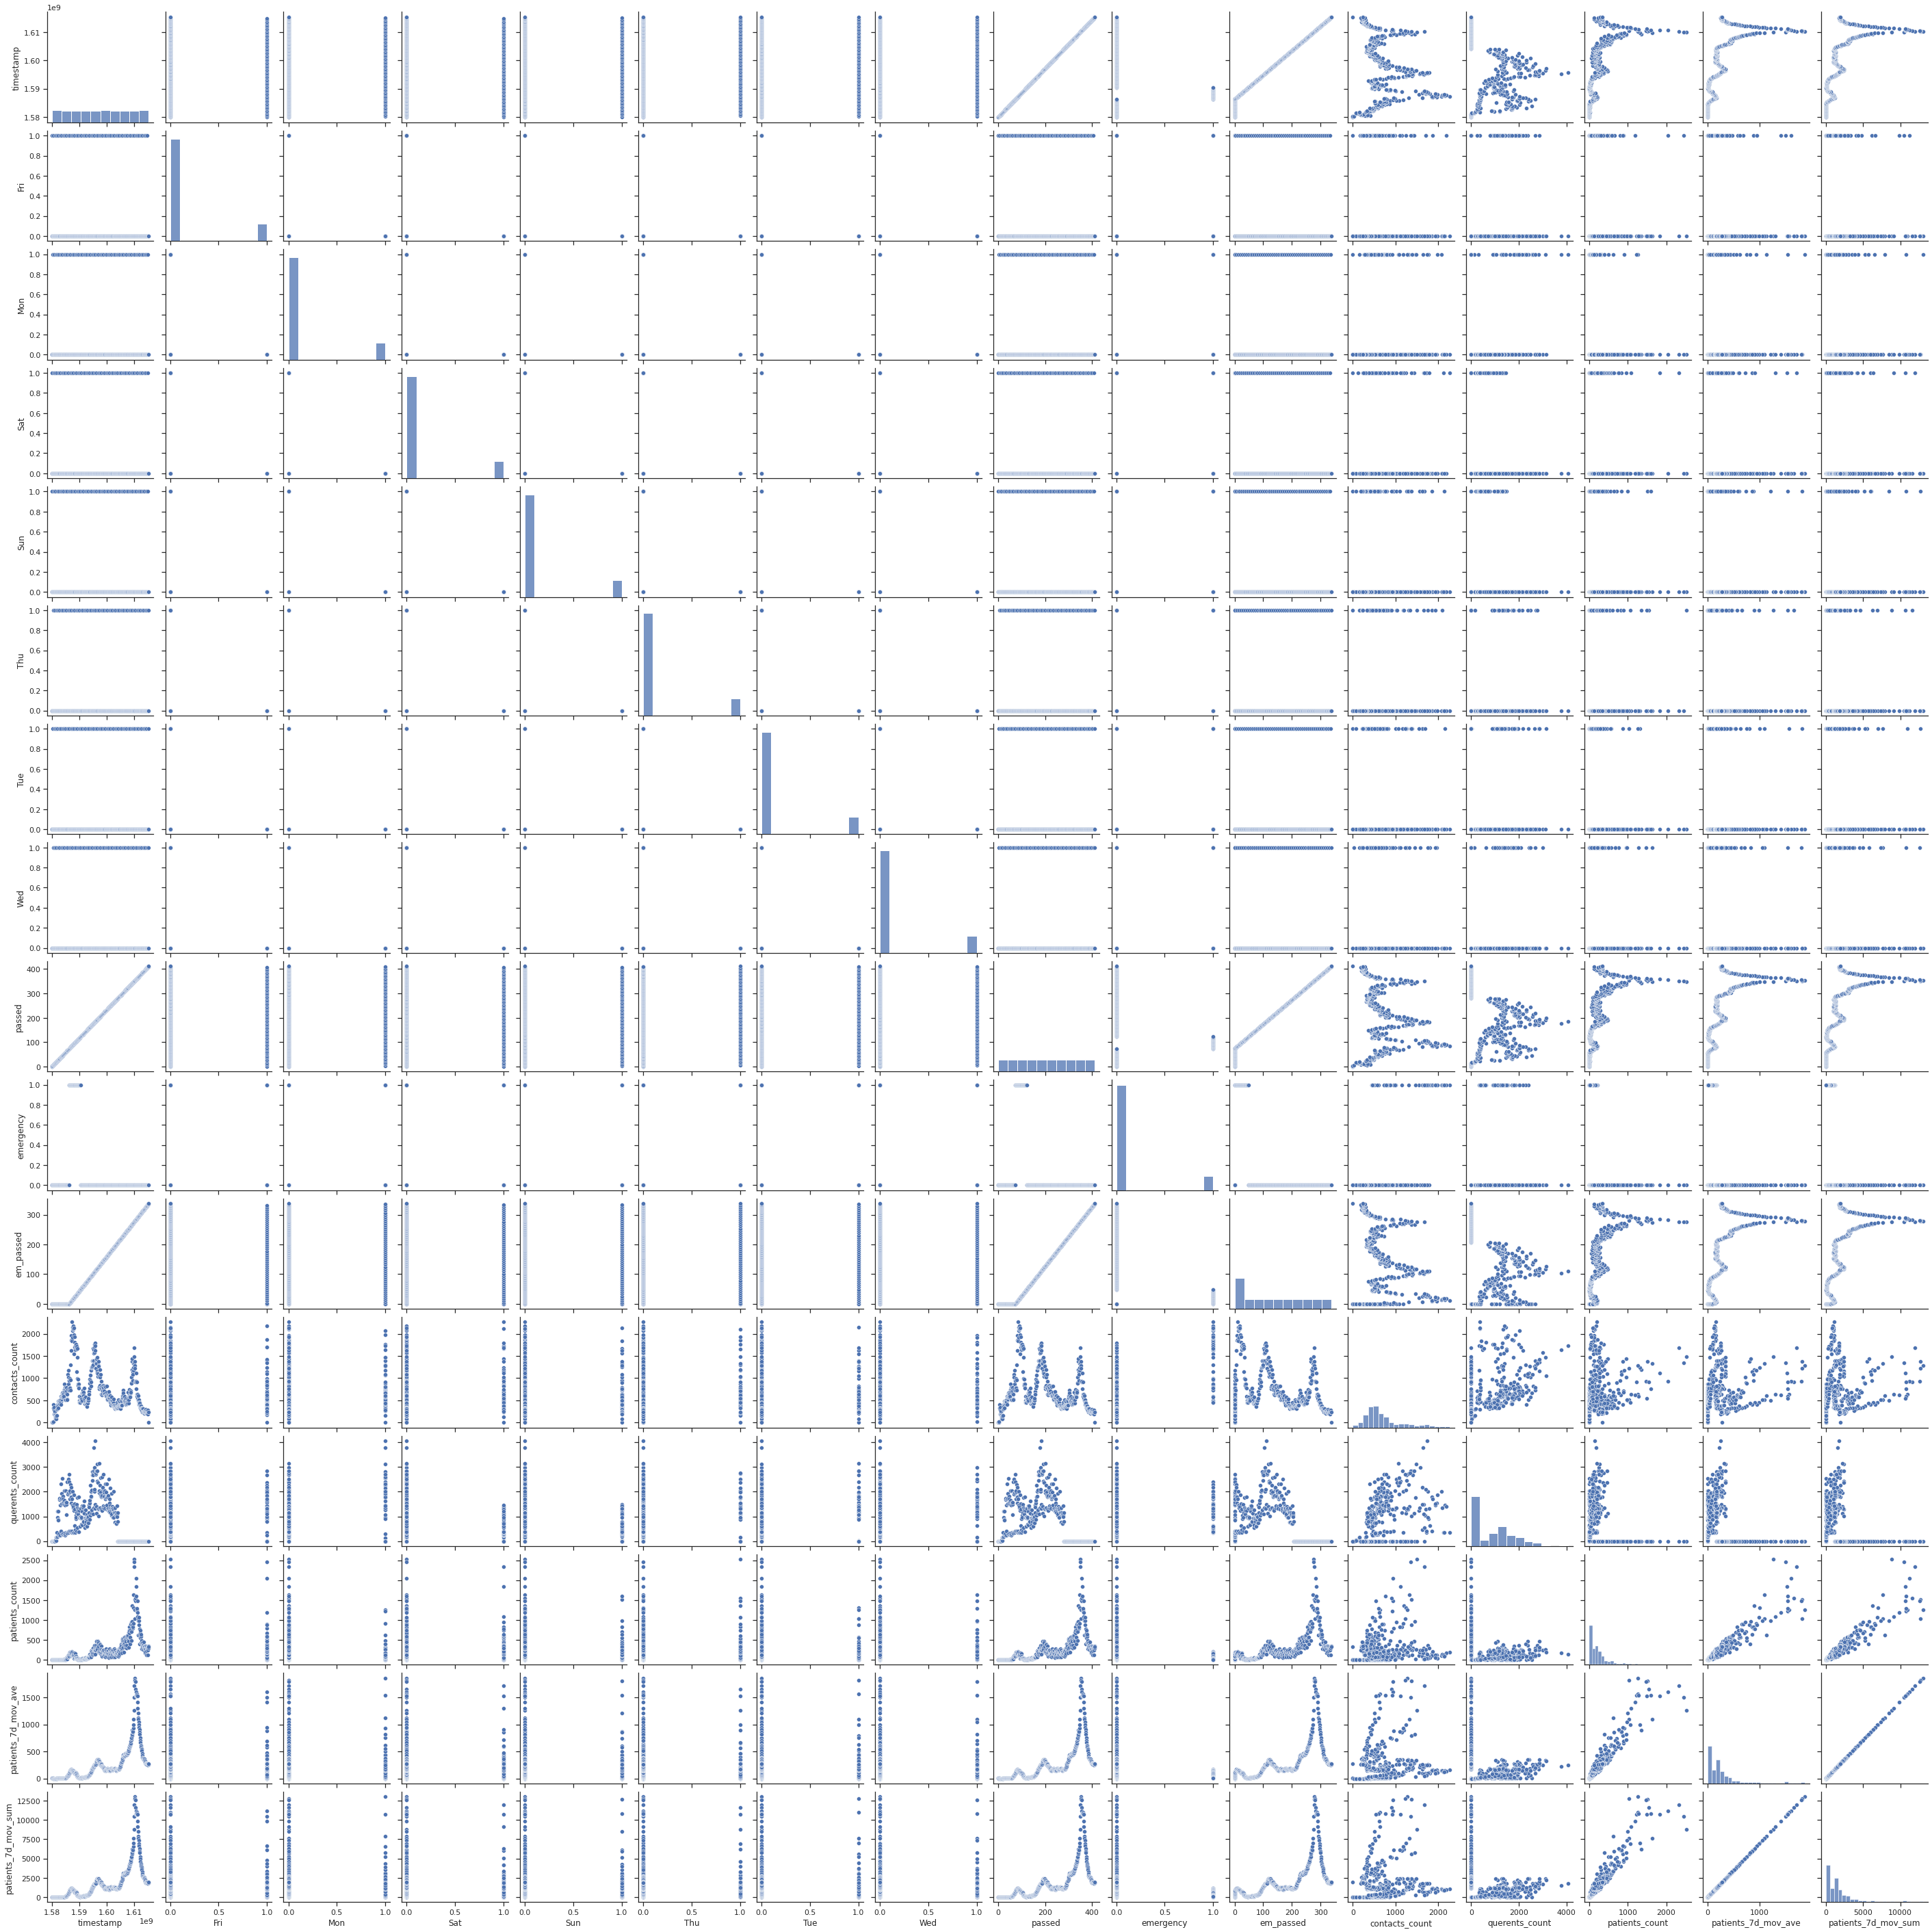

In [27]:
sns.set(style="ticks", color_codes=True)
sns.pairplot(data=_df)

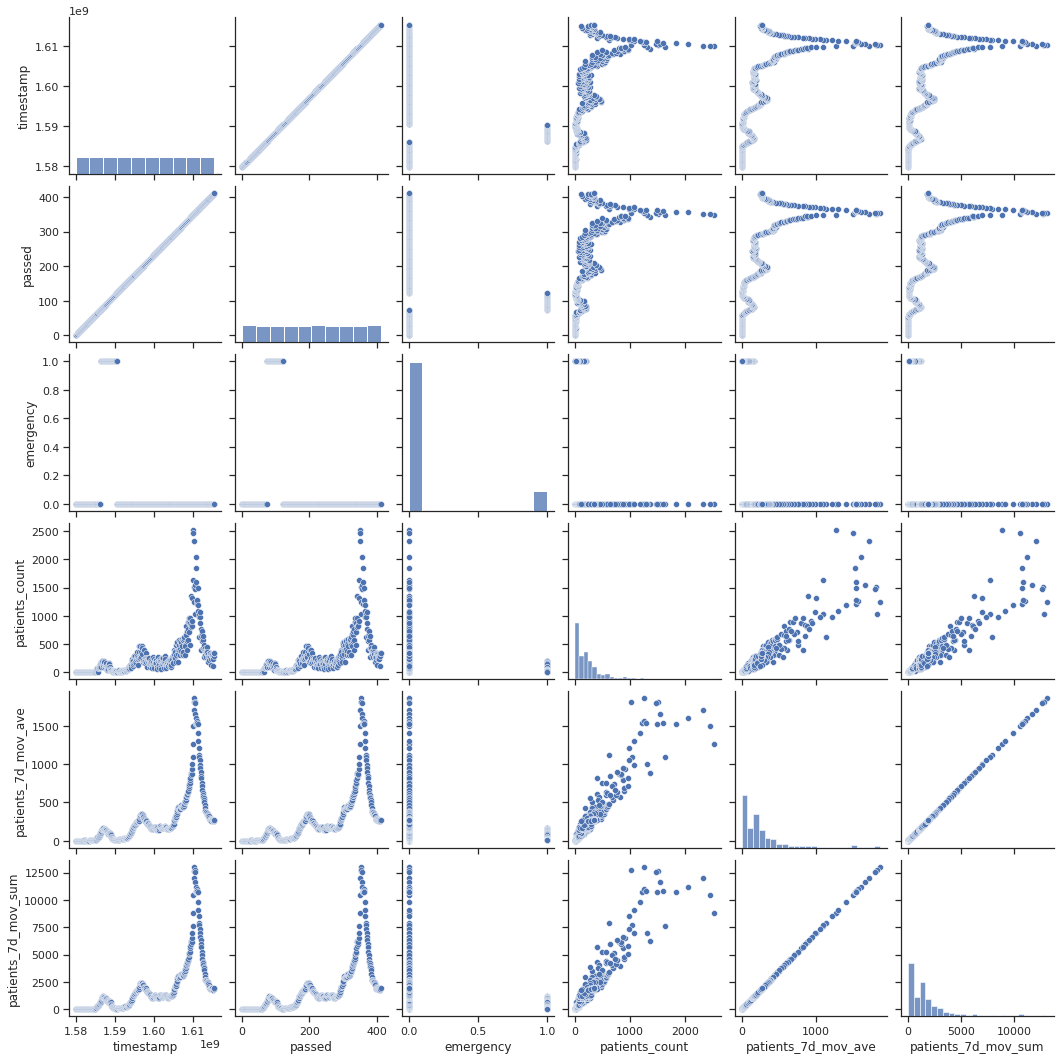

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.10
